# Prediciting your Future order

This notebook is implementing a predictive analysis model, that predicts the products ordered in users' future order based on each purchasing history.

# Model Usage

## How this model will make better customer shopping expireince?

Customers tend to do things quick and in an easy way. Thus can integrate this model with instacart's shopping software to initially autofill user's basket once openned the application.

In [34]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from google.cloud import bigquery
from pandas_gbq import read_gbq, to_gbq
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
import graphviz
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
from google.cloud import bigquery
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix

In [15]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rishikeshdhokare/Documents/Ironhack/instacart-441209-84de4dcbf601.json"
project_id = 'instacart-441209'
DATABASE_URI = f'bigquery://{project_id}'
engine = create_engine(DATABASE_URI)

/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_21844/3992139871.py:5: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


# What are the top 10 products

   product_id            product_name  AddToCartCount
0       24852                  Banana          115521
1       13176  Bag of Organic Bananas           82877
2       27845      Organic Whole Milk           32071
3       21137    Organic Strawberries           28875
4       47209    Organic Hass Avocado           24913
5       21903    Organic Baby Spinach           24412
6       47766         Organic Avocado           23393
7       19660            Spring Water           17552
8       16797            Strawberries           17073
9       27966     Organic Raspberries           14950


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_1400/1875178850.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AddToCartCount', y='product_name', data=top_products_df, palette='viridis')


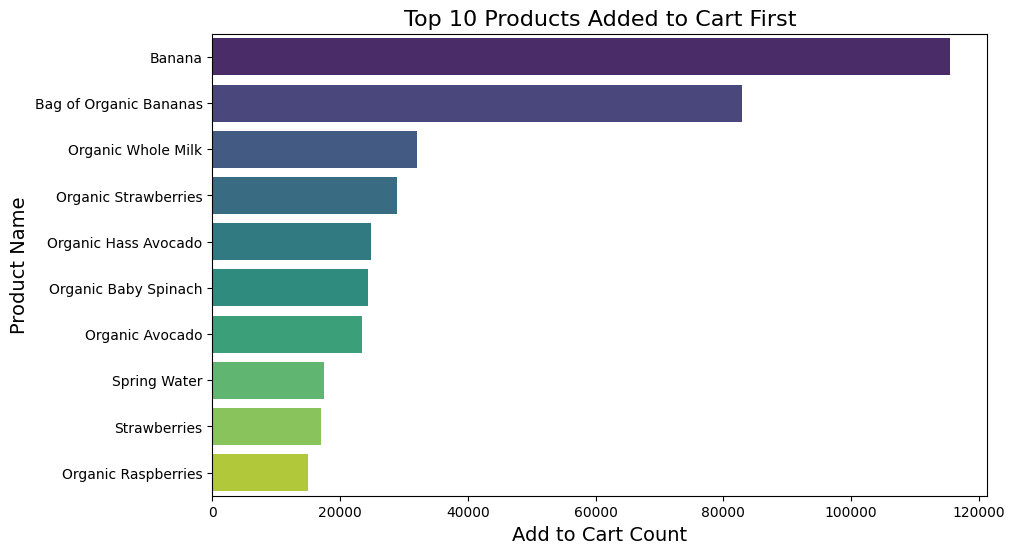

Results have been saved to top_10_products.csv


In [19]:
# Create a function to fetch the top 5 products added to the cart first
def get_top_products(project_id):
    top_products_query = """
    WITH CombinedOrderProducts AS (
        SELECT product_id, add_to_cart_order
        FROM `instacart-441209.instacart.order_products_prior`
        UNION ALL
        SELECT product_id, add_to_cart_order
        FROM `instacart-441209.instacart.order_products_train`
    )

    SELECT c.product_id,
           p.product_name,
           COUNT(*) AS AddToCartCount
    FROM CombinedOrderProducts c
    JOIN `instacart-441209.instacart.products` p
    ON p.product_id = c.product_id
    WHERE c.add_to_cart_order = 1
    GROUP BY c.product_id, p.product_name
    ORDER BY AddToCartCount DESC
    LIMIT 10;
    """
    client = bigquery.Client(project=project_id)
    query_job = client.query(top_products_query)
    top_products_df = query_job.to_dataframe()
    return top_products_df

# Call the function and print the result
top_products_df = get_top_products(project_id)
print(top_products_df)

# Plotting the results 
plt.figure(figsize=(10, 6))
sns.barplot(x='AddToCartCount', y='product_name', data=top_products_df, palette='viridis')
plt.title('Top 10 Products Added to Cart First', fontsize=16)
plt.xlabel('Add to Cart Count', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.show()

# Save results to CSV
top_products_df.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/top_10_products.csv", index=False)
print("Results have been saved to top_10_products.csv")

## Top Users based on total products ordered

   user_id  total_products_ordered
0   201268                    3725
1   129928                    3638
2   164055                    3061
3   186704                    2936
4   176478                    2921
5   182401                    2907
6   137629                    2901
7    33731                    2888
8   108187                    2760
9     4694                    2735


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_1400/3408503746.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='user_id', y='total_products_ordered', data=top_users_df, palette='viridis',


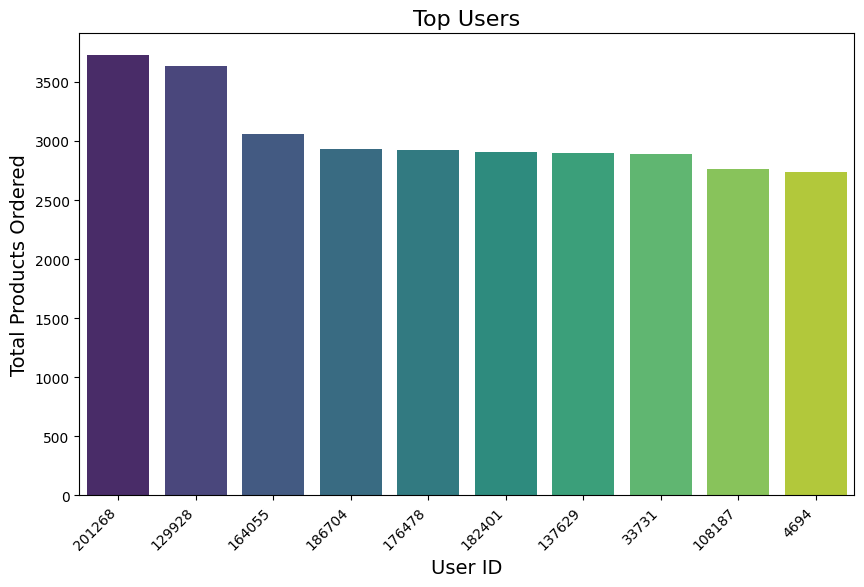

Results have been saved to top_users.csv


In [23]:
# Create a method to fetch the top users and plot the graph in the desired order
def get_top_users_and_plot(project_id):
    # Define the SQL query
    top_users_query = """
    WITH UserOrderCounts AS (
        SELECT o.user_id,
               COUNT(op.product_id) AS total_products_ordered
        FROM `instacart-441209.instacart.order_products_prior` op
        JOIN `instacart-441209.instacart.orders` o
        ON op.order_id = o.order_id
        GROUP BY o.user_id
    )
    SELECT uoc.user_id, uoc.total_products_ordered
    FROM UserOrderCounts uoc
    ORDER BY uoc.total_products_ordered DESC
    LIMIT 10;
    """
    client = bigquery.Client(project=project_id)
    query_job = client.query(top_users_query)
    top_users_result = query_job.result()
    top_users_df = top_users_result.to_dataframe()
    print(top_users_df)
    top_users_df = top_users_df.sort_values(by='total_products_ordered', ascending=False)
    return top_users_df
    
# Call the method to fetch and plot the top users
top_users_df = get_top_users_and_plot(project_id)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='total_products_ordered', data=top_users_df, palette='viridis',
                order=top_users_df['user_id'])
plt.title('Top Users', fontsize=16)
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Total Products Ordered', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

# Save results to CSV
top_users_df.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/top_users.csv", index=False)
print("Results have been saved to top_users.csv")

## Daily order distribution

  day_of_week  order_count
0      Sunday       600905
1      Monday       587478
2     Tuesday       467260
3   Wednesday       436972
4    Thursday       426339
5      Friday       453368
6    Saturday       448761


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_1400/796684860.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='order_count', data=daily_orders_df, palette='viridis')


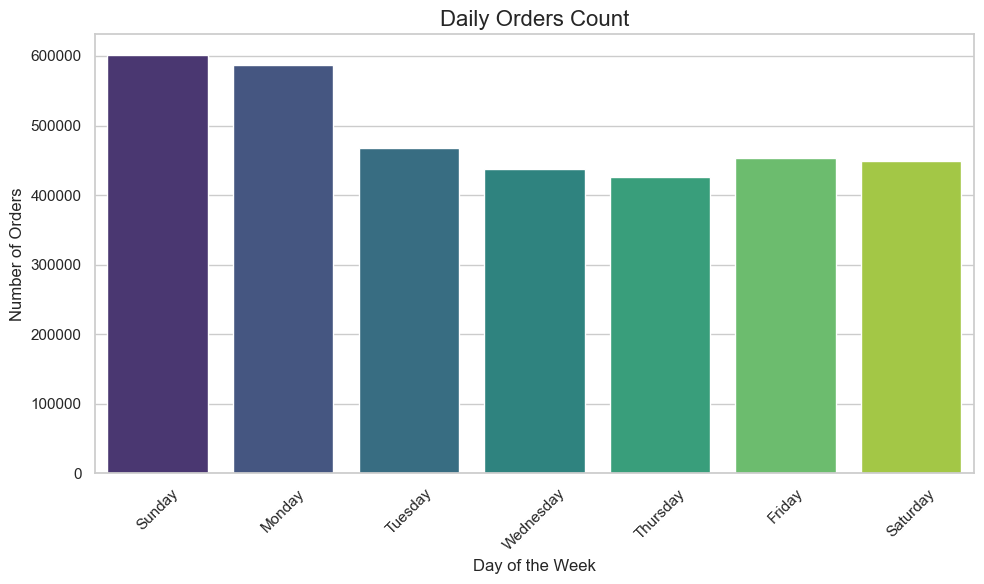

Results have been saved to daily_orders.csv


In [27]:
def get_daily_orders():
    daily_orders_query = """    
    SELECT
       CASE
         WHEN order_dow = 0 THEN 'Sunday'
         WHEN order_dow = 1 THEN 'Monday'
         WHEN order_dow = 2 THEN 'Tuesday'
         WHEN order_dow = 3 THEN 'Wednesday'
         WHEN order_dow = 4 THEN 'Thursday'
         WHEN order_dow = 5 THEN 'Friday'
         WHEN order_dow = 6 THEN 'Saturday'
      END AS day_of_week,
      COUNT(order_id) AS order_count   
    FROM `instacart-441209.instacart.orders`
    GROUP BY order_dow
    ORDER BY order_dow;
    """
    client = bigquery.Client()
    query_job = client.query(daily_orders_query)
    daily_orders_result = query_job.result()  # Correct variable name
    daily_orders_df = daily_orders_result.to_dataframe()
    print(daily_orders_df)
    
    return daily_orders_df

# Call the method
daily_orders_df = get_daily_orders()

# Plot Graph
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.barplot(x='day_of_week', y='order_count', data=daily_orders_df, palette='viridis')
plt.title('Daily Orders Count', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

daily_orders_df.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/daily_orders.csv", index=False)
print("Results have been saved to daily_orders.csv")


## Get ordered Products for user 

In [48]:
def get_ordered_and_carted_products(user_id):
    combined_query = f"""
    WITH CombinedOrderProducts AS (
        SELECT order_id, product_id
        FROM `instacart-441209.instacart.order_products_prior`
        UNION ALL
        SELECT order_id, product_id
        FROM `instacart-441209.instacart.order_products_train`
    )
    SELECT 
        o.user_id,
        o.order_id,
        p.product_name,
        op.product_id
    FROM CombinedOrderProducts op
    JOIN `instacart-441209.instacart.products` p ON op.product_id = p.product_id
    JOIN `instacart-441209.instacart.orders` o ON op.order_id = o.order_id
    WHERE o.user_id = {user_id}
    ORDER BY o.order_id, p.product_name;
    """
    
    client = bigquery.Client()
    query_job = client.query(combined_query)
    result_df = query_job.to_dataframe()
    user_product_ids = result_df['product_id'].unique().tolist()
    return user_product_ids, result_df


# Fetch and display data
user_id = 164055
user_product_ids, user_ordered_carted_products_df = get_ordered_and_carted_products(user_id)
print("Original Data:")
print(user_ordered_carted_products_df)

grouped_df = user_ordered_carted_products_df.groupby('order_id')['product_name'].apply(lambda x: ', '.join(x)).reset_index()
print("\nGrouped by Order ID:")

Original Data:
      user_id  order_id                     product_name  product_id
0      164055     18426  American Cheese Slices 12 Count        1263
1      164055     18426                   Broccoli Crown        8424
2      164055     18426                   Cello Tomatoes       26477
3      164055     18426      Chocolate Chip Cookie Dough       27288
4      164055     18426      Classic Roast Ground Coffee       26111
...       ...       ...                              ...         ...
3084   164055   3375344             Sriracha Chili Sauce       23032
3085   164055   3375344                    String Cheese       11869
3086   164055   3375344                     Tomato Juice       36897
3087   164055   3375344             Wheat Sandwich Bread        1157
3088   164055   3375344             White Sandwich Bread       21497

[3089 rows x 4 columns]

Grouped by Order ID:
   order_id                                       product_name
0     18426  American Cheese Slices 12 Count, B

In [50]:
grouped_df.head(10)

,order_id,product_name
0,18426,"American Cheese Slices 12 Count, Broccoli Crow..."
1,69518,"2% Reduced Fat Milk, American Cheese Slices 12..."
2,90373,100% Whole Wheat Medium Soft Taco Flour Tortil...
3,97656,"100% Orange Juice, American Cheese Slices 12 C..."
4,98372,100% Whole Wheat Medium Soft Taco Flour Tortil...
5,174416,"100% Orange Juice, Broccoli Crown, Cinnamon Ce..."
6,184214,"2% Reduced Fat Milk, American Cheese Slices 12..."
7,209129,100% Whole Wheat Medium Soft Taco Flour Tortil...
8,214927,"100% Orange Juice, Balsamic Vinaigrette Dressi..."
9,233491,"100% Orange Juice, American Cheese Slices 12 C..."


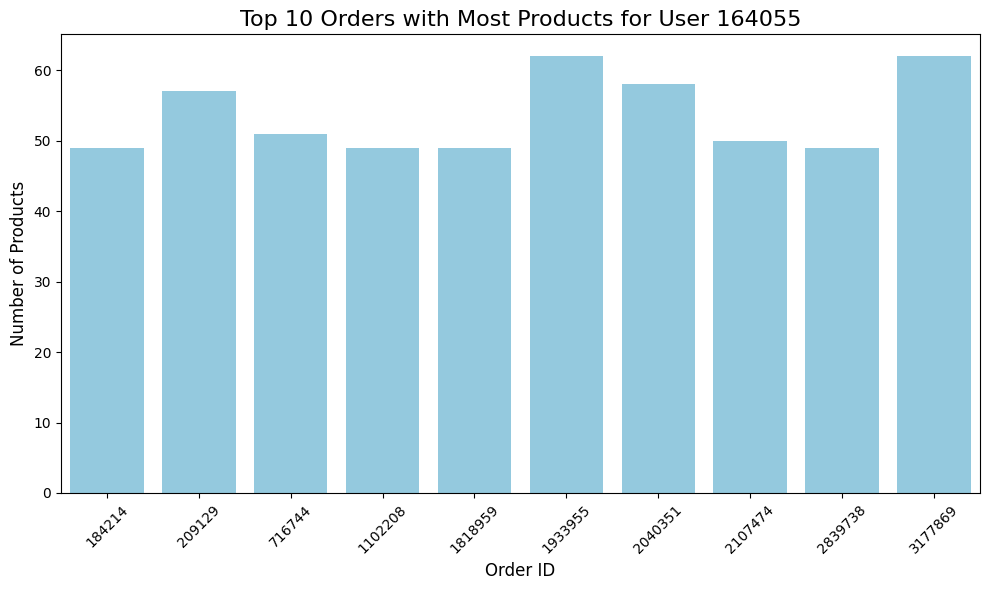

In [44]:
grouped_df['product_count'] = grouped_df['product_name'].apply(lambda x: len(x.split(',')))
top_10_orders = grouped_df.sort_values(by='product_count', ascending=False).head(10)

# Plotting the bar chart for the top 10 orders
plt.figure(figsize=(10, 6))
sns.barplot(x='order_id', y='product_count', data=top_10_orders, color='skyblue')

# Adding labels and title
plt.title(f"Top 10 Orders with Most Products for User {user_id}", fontsize=16)
plt.xlabel("Order ID", fontsize=12)
plt.ylabel("Number of Products", fontsize=12)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()

## Top Product Pairs Based on Purchase Frequency

Top Product Pairs Based on Purchase Frequency:
   product_id_1          product_name_1  product_id_2        product_name_2  \
0         13176  Bag of Organic Bananas         47209  Organic Hass Avocado   
1         13176  Bag of Organic Bananas         21137  Organic Strawberries   
2         21137    Organic Strawberries         24852                Banana   
3         24852                  Banana         47766       Organic Avocado   
4         21903    Organic Baby Spinach         24852                Banana   
5         13176  Bag of Organic Bananas         21903  Organic Baby Spinach   
6         16797            Strawberries         24852                Banana   
7         24852                  Banana         47626           Large Lemon   
8         21137    Organic Strawberries         47209  Organic Hass Avocado   
9         13176  Bag of Organic Bananas         27966   Organic Raspberries   

   purchase_count  
0           64761  
1           64702  
2           58330  
3  

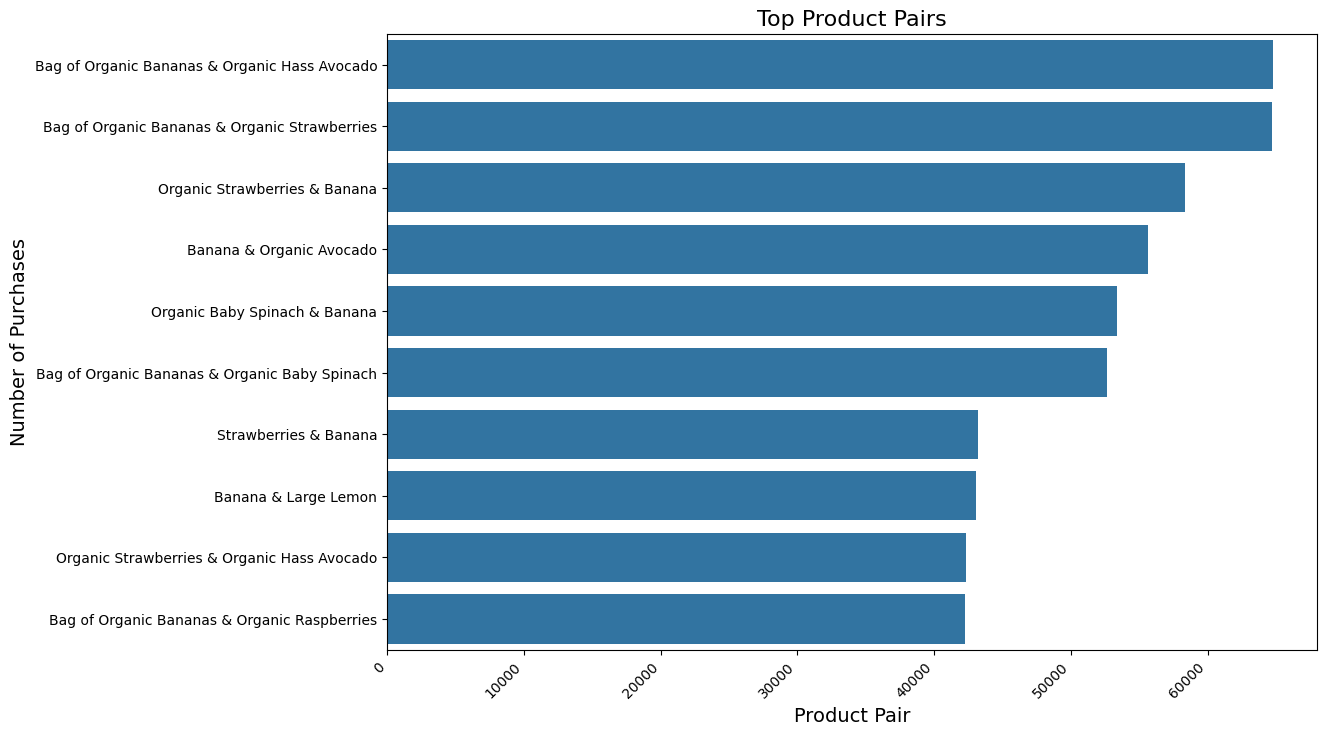

Results have been saved to top_product_pairs.csv


In [54]:
# Method to fetch the top product pairs based on purchase frequency
def get_top_product_pairs():
    pair_combinations_query = """
    WITH CombinedOrders AS (
        SELECT order_id, product_id
        FROM `instacart-441209.instacart.order_products_prior`
        UNION ALL
        SELECT order_id, product_id
        FROM `instacart-441209.instacart.order_products_train`
    )

    SELECT
        p1.product_id AS product_id_1,
        p1.product_name AS product_name_1,
        p2.product_id AS product_id_2,
        p2.product_name AS product_name_2,
        COUNT(*) AS purchase_count
    FROM CombinedOrders co1
    JOIN CombinedOrders co2 ON co1.order_id = co2.order_id AND co1.product_id < co2.product_id
    JOIN `instacart-441209.instacart.products` p1 ON co1.product_id = p1.product_id
    JOIN `instacart-441209.instacart.products` p2 ON co2.product_id = p2.product_id
    GROUP BY p1.product_id, p1.product_name, p2.product_id, p2.product_name
    ORDER BY purchase_count DESC
    LIMIT 10;
    """
    pair_combinations_df = pd.read_sql(pair_combinations_query, engine)
    return pair_combinations_df

# Fetch top product pairs
top_product_pairs_df = get_top_product_pairs()
print("Top Product Pairs Based on Purchase Frequency:")
print(top_product_pairs_df)

# Create a new column combining product names
top_product_pairs_df['product_pair'] = top_product_pairs_df['product_name_1'] + " & " + top_product_pairs_df['product_name_2']
print(top_product_pairs_df)

# Plotting the top product pairs with purchase_count 
plt.figure(figsize=(12, 8))
sns.barplot(y='product_pair', x='purchase_count', data=top_product_pairs_df)
plt.title('Top Product Pairs', fontsize=16)
plt.xlabel('Product Pair', fontsize=14)
plt.ylabel('Number of Purchases', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()


# Save results to CSV
top_product_pairs_df.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/top_product_pairs.csv", index=False)
print("Results have been saved to top_product_pairs.csv")

## Recommended Products for User

In [56]:
def get_recommendations(user_id):
    
    user_product_ids, user_products_df = get_ordered_and_carted_products(user_id)
    pair_combinations_df = get_top_product_pairs()
    recommendations = set()

    # Check if the user has ordered products in the frequent pairs
    for _, row in pair_combinations_df.iterrows():
        if row['product_id_1'] not in user_product_ids:
            recommendations.add(row['product_name_1'])
        if row['product_id_2'] not in user_product_ids:
            recommendations.add(row['product_name_2'])

    # Add more products if fewer than 5 recommendations
    if len(recommendations) < 5:
        additional_products = []
        for _, row in pair_combinations_df.iterrows():
            if row['product_id_1'] not in user_product_ids and row['product_name_1'] not in recommendations:
                additional_products.append(row['product_name_1'])
            if row['product_id_2'] not in user_product_ids and row['product_name_2'] not in recommendations:
                additional_products.append(row['product_name_2'])

        for product in additional_products:
            if len(recommendations) >= 5:
                break
            recommendations.add(product)

    return list(recommendations)[:5]

# Specify the user ID
user_id = 143095
recommended_products = get_recommendations(user_id)
print(f"Recommended Products for User {user_id}: {recommended_products}")

Recommended Products for User 143095: ['Organic Strawberries', 'Banana', 'Bag of Organic Bananas', 'Organic Hass Avocado', 'Large Lemon']


In [60]:
recommended_products

['Organic Strawberries',
 'Banana',
 'Bag of Organic Bananas',
 'Organic Hass Avocado',
 'Large Lemon']

## Predicted Next Order for User

In [42]:
# Method to fetch the user's reordered products and their frequencies
def get_user_order_frequencies(user_id):
    user_order_freq_query = f"""
    SELECT 
        op.product_id,
        p.product_name,
        COUNT(op.order_id) AS order_count,
        SUM(op.reordered) AS reorder_count
    FROM `instacart-441209.instacart.order_products_prior` op
    JOIN `instacart-441209.instacart.orders` o ON op.order_id = o.order_id
    JOIN `instacart-441209.instacart.products` p ON op.product_id = p.product_id
    WHERE o.user_id = {user_id}
    GROUP BY op.product_id, p.product_name
    ORDER BY reorder_count DESC, order_count DESC
    """
    user_order_freq_df = pd.read_sql(user_order_freq_query, engine)
    return user_order_freq_df

# Method to predict the user's next order
def predict_next_order(user_id, top_n=10):
    user_order_freq_df = get_user_order_frequencies(user_id)
    next_order_prediction = user_order_freq_df[user_order_freq_df['reorder_count'] > 0]
    next_order_prediction = next_order_prediction.head(top_n)
    return next_order_prediction[['product_name', 'order_count', 'reorder_count']]

# Specify the user ID 
user_id = 143095
predicted_next_order = predict_next_order(user_id)
print(f"Predicted Next Order for User {user_id}:\n{predicted_next_order}")


Predicted Next Order for User 143095:
                                     product_name  order_count  reorder_count
0            Honey Bunches Of Oats Roasted Cereal            7              6
1                       Regular Pork Sausage Tube            5              4
2  Unsweetened Original Almond Breeze Almond Milk            4              3
3                    Bathroom Tissue Double Rolls            4              3
4                          Dentastix Fresh, Large            4              3
5     Sensitive Skin Moisturizing Cream Soap Bars            4              3
6             Cage Free Brown Eggs-Large, Grade A            3              2
7                                         Avocado            3              2
8                               Dried Blueberries            3              2
9                                  Steel Cut Oats            3              2


### Feature Engineering:

In [17]:
query = """
SELECT
    op.order_id,
    op.product_id,
    op.add_to_cart_order,
    op.reordered,
    p.product_name,
    p.aisle_id,
    p.department_id,
    a.aisle,
    d.department,
    o.user_id,
    o.eval_set,
    o.order_number,
    o.order_dow,
    o.order_hour_of_day,
    o.days_since_prior_order
FROM
    `instacart-441209.instacart.order_products_train` AS op
JOIN
    `instacart-441209.instacart.products` AS p
    ON op.product_id = p.product_id
JOIN
    `instacart-441209.instacart.aisles` AS a
    ON p.aisle_id = a.aisle_id
JOIN
    `instacart-441209.instacart.departments` AS d
    ON p.department_id = d.department_id
JOIN
    `instacart-441209.instacart.orders` AS o
    ON op.order_id = o.order_id
LEFT JOIN
    `instacart-441209.instacart.order_products_prior` AS op_prior
    ON op_prior.order_id = op.order_id AND op_prior.product_id = op.product_id
"""
client = bigquery.Client()
query_job = client.query(query)
combined_df = query_job.to_dataframe()

#Drop non-numeric columns
categorical_columns = ['product_name', 'eval_set']
for col in categorical_columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])
    
# Encode 'aisle' and 'department' columns using get_dummies
combined_df = pd.get_dummies(combined_df, columns=['aisle', 'department', 'eval_set'], drop_first=True)

In [ ]:
# Correlation matrix
correlation_matrix = combined_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix with YlGnBu Color Palette")
plt.show()

## Define Feature and Target

In [19]:
features = combined_df.drop(columns=['reordered', 'product_name'])
target = combined_df['reordered']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Modeling

## XGBoost Classifier

Accuracy: 0.68
[[ 55427  55436]
 [ 31878 134183]]
              precision    recall  f1-score   support

         0.0       0.63      0.50      0.56    110863
         1.0       0.71      0.81      0.75    166061

    accuracy                           0.68    276924
   macro avg       0.67      0.65      0.66    276924
weighted avg       0.68      0.68      0.68    276924



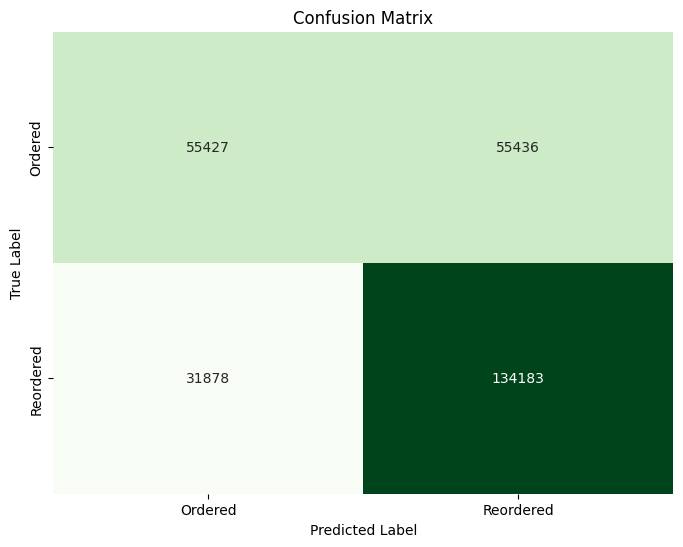

In [21]:
model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Ordered", "Reordered"], yticklabels=["Ordered", "Reordered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [32]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
conf_matrix_df.to_csv('/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/confusion_matrix_next_order.csv')

### KNN Model

In [ ]:
normalizer = MinMaxScaler()
normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_norm, y_train)

pred = knn.predict(X_test_norm)

knn_acuracy = knn.score(X_test_norm, y_test)
print("KNN Model Accuray:", knn_acuracy)

## Linear Regression

In [420]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", lin_reg.score(X_test, y_test))

MAE 0.645561335272743
RMSE 0.7467140688586812
R2 score -1.9737701367012654


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Decision Tree Regressor

In [406]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_norm, y_train)
pred = tree.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", tree.score(X_test_norm, y_test))

MAE 0.0
RMSE 0.0
R2 score 1.0


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Random Forest Regressor

In [408]:
# Initialize and train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate and display performance metrics 
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", tree.score(X_test_norm, y_test))
print(f'Feature Importances: {rf_regressor.feature_importances_}')

MAE 0.0
RMSE 0.0
R2 score 1.0
Feature Importances: [0.47959184 0.51020408 0.         0.01020408]


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Add Cluster-Based Features

In [410]:
user_order_freq_df['target'] = (user_order_freq_df['reorder_count'] > 0).astype(int)

# Define the clustering features
X_clustering = user_order_freq_df[['order_count', 'product_id', 'total_order_count']]
y = user_order_freq_df['target']

# Perform KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
user_order_freq_df['cluster'] = kmeans.fit_predict(X_clustering)

# Now include the 'cluster' feature in the main dataset
X = user_order_freq_df[['order_count', 'product_id', 'total_order_count', 'cluster']]

# Split the data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model with regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

predicted_prob = rf_model.predict([[50, 0.5, 2, 1]])[0]
print(f"Predicted next order score (with clustering): {predicted_prob:.2f}")


Mean Absolute Error: 0.064
Mean Squared Error: 0.00524
R2 Score: 0.9781666666666666
Predicted next order score (with clustering): 0.92


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
